<font size="+2">Training a Street Situation Detection Network</font>


This project deals with the problem of detecting street situation images (images which are taken on the outside). The used dataset for training the network, was self-created. In order to get a copy of the dataset, contact s0558366@htw-berlin.de

# Requirements

## Imports

In [1]:
import os
import pathlib

import tensorflow as tf
from tensorflow import keras
print('TensorFlow version: {}'.format(tf.__version__))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

TensorFlow version: 2.1.0


## Training configuration

In [2]:
BATCH_SIZE = 32
EPOCHS = 50

IMG_HEIGHT = 299
IMG_WIDTH = 299

TRAIN = True

LEARNING_RATE = 0.001
DECAY_STEP = 500
DECAY_RATE = 0.97

STOP_TRAINING_EARLY_AFTER_N_EPOCHS = 10

In [3]:
CLASSES = ["no street", "street"]

# Dataset

## Training dataset

The training dataset is a collection of street situations. The positive examples for a street image, were randomly selected from following datasets:

- [BDD100K Dataset](https://bair.berkeley.edu/blog/2018/05/30/bdd/)
- [Mapillary Vistas Dataset](https://www.mapillary.com/dataset/vistas?pKey=q0GhQpk20wJm1ba1mfwJmw&lat=20&lng=0&z=1.5)
- [Cityscapes Dataset](https://www.cityscapes-dataset.com/)

The negative examples were randomly selected from the [ImageNet](http://image-net.org/) validation dataset. Overall there are 12.000 images, split into a into a `train` (10.000 images) and `validation` (2000) images dataset. In each dataset the percentage of positive and negative example is 50%.

In [4]:
street_situation_dataset_path = "./street-situation-dataset"

In [5]:
train_data_dir = os.path.join(street_situation_dataset_path, "train")
train_data_dir = pathlib.Path(train_data_dir)

train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                 rotation_range=20,
                                                                 shear_range=0.2,
                                                                 zoom_range=0.2,
                                                                 horizontal_flip=True)

train_data_gen = train_data_gen.flow_from_directory(directory=str(train_data_dir),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 10000 images belonging to 2 classes.


In [6]:
val_data_dir = os.path.join(street_situation_dataset_path, "validation")
val_data_dir = pathlib.Path(val_data_dir)

val_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

val_data_gen = val_data_gen.flow_from_directory(directory=str(val_data_dir),
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2000 images belonging to 2 classes.


## Evaluation images

In [7]:
test_data_dir = "./evaluation-images"
test_data_dir = pathlib.Path(test_data_dir)

test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_data_gen = test_data_gen.flow_from_directory(directory=str(test_data_dir),
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=False,
                                                  target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 37 images belonging to 2 classes.


## Dataet visualization

In [8]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(15,15))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.title(np.argmax(label_batch[n]))
        plt.imshow(image_batch[n])
        plt.axis('off')

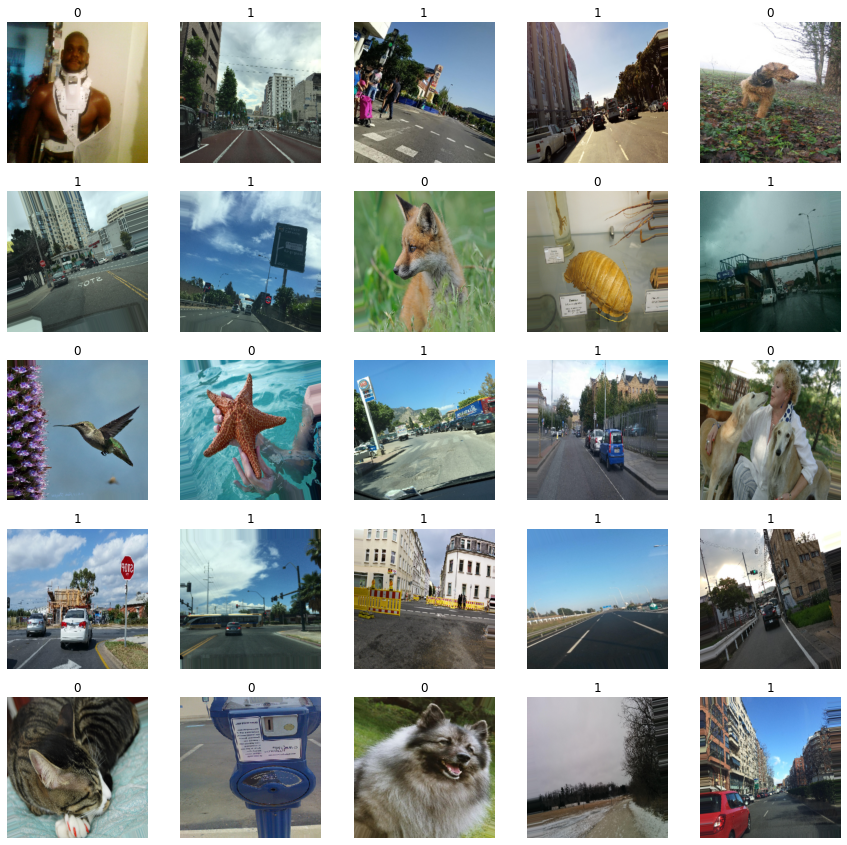

In [9]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

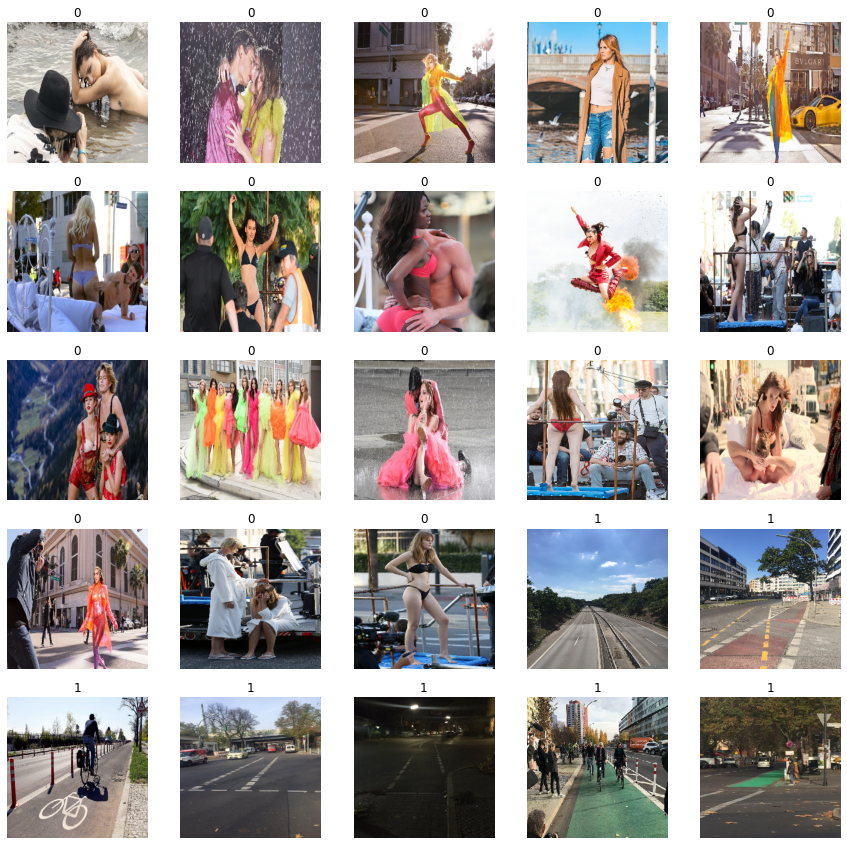

In [10]:
image_batch, label_batch = next(test_data_gen)
show_batch(image_batch, label_batch)

# Street Situation Detection Network

## Building the model

In [11]:
def create_model():
    base_model = keras.applications.ResNet50V2(weights="imagenet", include_top=False)
    for layer in base_model.layers:
        layer.trainable = False
    
    model = base_model.output
    model = keras.layers.GlobalAveragePooling2D()(model)
    model = keras.layers.Dense(1024, activation='relu')(model)
    
    predictions = keras.layers.Dense(2, activation='softmax')(model)
    return keras.models.Model(inputs=base_model.input, outputs=predictions)

In [12]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    LEARNING_RATE, decay_steps=DECAY_STEP, decay_rate=DECAY_RATE, staircase=True
)
adam = keras.optimizers.Adam(learning_rate=lr_schedule)

In [14]:
model.compile(optimizer=adam, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Defining callbacks

In [15]:
log_dir = os.path.join('logs')
os.makedirs(log_dir, exist_ok=True)

checkpoint_dir= os.path.join(log_dir, 'model_{epoch}')

In [16]:
tensorboard_cbk = keras.callbacks.TensorBoard(log_dir=log_dir,
                                              write_images=True,
                                              histogram_freq=0,  # How often to log histogram visualizations
                                              embeddings_freq=0,  # How often to log embedding visualizations
                                              update_freq='epoch')

In [17]:
checkpoint_cbk = keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                                 # Path where to save the model
                                                 # The two parameters below mean that we will overwrite
                                                 # the current checkpoint if and only if
                                                 # the `val_loss` score has improved.
                                                 save_best_only=True,
                                                 monitor='val_loss',
                                                 verbose=1)

In [18]:
early_stoppidng = keras.callbacks.EarlyStopping(# Stop training when `val_loss` is no longer improving
                                                monitor="val_loss",
                                                # "no longer improving" being defined as "no better than 1e-2 less"
                                                min_delta=1e-3,
                                                # "no longer improving" being further defined as "for at least 2 epochs"
                                                patience=STOP_TRAINING_EARLY_AFTER_N_EPOCHS,
                                                verbose=1)

In [19]:
callbacks = [tensorboard_cbk, checkpoint_cbk, early_stoppidng]

## Train the model

In [20]:
if TRAIN:
    model.fit(train_data_gen, epochs=EPOCHS, validation_data=val_data_gen,  callbacks=callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 313 steps, validate for 63 steps
Epoch 1/50
312/313 [============================>.] - ETA: 1s - loss: 0.1066 - accuracy: 0.9594
Epoch 00001: val_loss improved from inf to 0.26512, saving model to logs\model_1
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: logs\model_1\assets
313/313 [==============================] - 371s 1s/step - loss: 0.1063 - accuracy: 0.9595 - val_loss: 0.2651 - val_accuracy: 0.9245
Epoch 2/50
312/313 [============================>.] - ETA: 0s - loss: 0.0638 - accuracy: 0.9761
Epoch 00002: val_loss did not improve from 0.26512
313/313 [==============================] - 347s 1s/step - loss: 0.0638 - accuracy: 0.9761 - val_loss: 0.3859 - val_accuracy: 0.8875
Epoch 3/50
312/313 [============================>.] - ETA: 0s - loss: 0.0477 - accuracy: 0.9824
Epoch 00003: val_loss did not improve from 0.26512
313/313 [===========================

# Performance analysis

## Load best model

In [21]:
all_model_dirs = [os.path.join(log_dir, d) for d in os.listdir(log_dir) if "model" in d]
latest_model_dir = max(all_model_dirs, key=os.path.getmtime)
best_model = keras.models.load_model(latest_model_dir)

## Helper

In [22]:
def create_confusion_matrix(labels, predictions, class_name=None):
    if not class_name:
        class_name = list(set(labels))
        
    con_mat = tf.math.confusion_matrix(labels=labels, 
                                       predictions=predictions).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(), decimals=2)
    con_mat_df = pd.DataFrame(con_mat_norm,
                         index = class_name, 
                         columns = class_name)

    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Performance on validation dataset

### Loss and accuracy

In [23]:
val_loss, val_acc = best_model.evaluate(val_data_gen)
print('\nVal loss: {} and accuracy: {}'.format(val_loss, val_acc))

  ...
    to  
  ['...']
63/63 [==============================] - 38s 601ms/step - loss: 0.1789 - accuracy: 0.9560

Val loss: 0.17891218226037023 and accuracy: 0.9559999704360962


### Confusion matrix

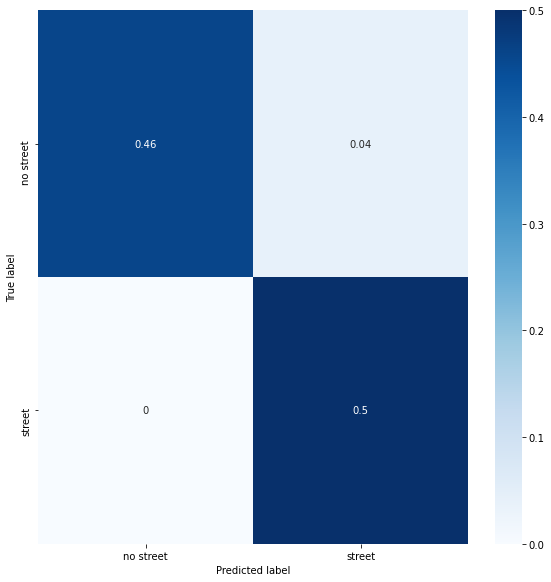

In [24]:
y_pred = best_model.predict(val_data_gen)
y_pred = np.argmax(y_pred, axis=1)
create_confusion_matrix(val_data_gen.classes, y_pred, CLASSES)

## Performance on evaluation images

### Loss and accuracy

In [25]:
test_loss, test_acc = best_model.evaluate(test_data_gen)
print('\nTestloss: {} and accuracy: {}'.format(test_loss, test_acc))

  ...
    to  
  ['...']
2/2 [==============================] - 2s 784ms/step - loss: 0.6576 - accuracy: 0.9189

Testloss: 0.6576054394245148 and accuracy: 0.9189189076423645


### Confusion matrix

In [28]:
X_test = []
batch_index = 0
while batch_index <= test_data_gen.batch_index:
    data = test_data_gen.next()[0]
    if len(X_test) == 0:
        X_test = data
    else:
        X_test = np.append(X_test, data, axis=0)
    
    batch_index = batch_index + 1

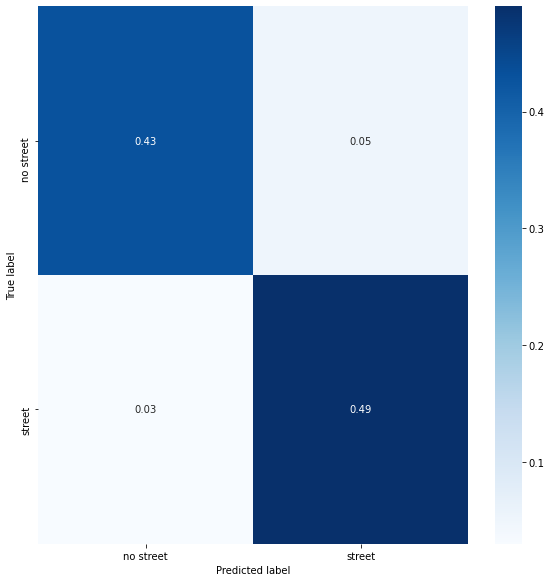

In [29]:
y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
create_confusion_matrix(test_data_gen.classes, y_pred, CLASSES)

### Visualization of predictions

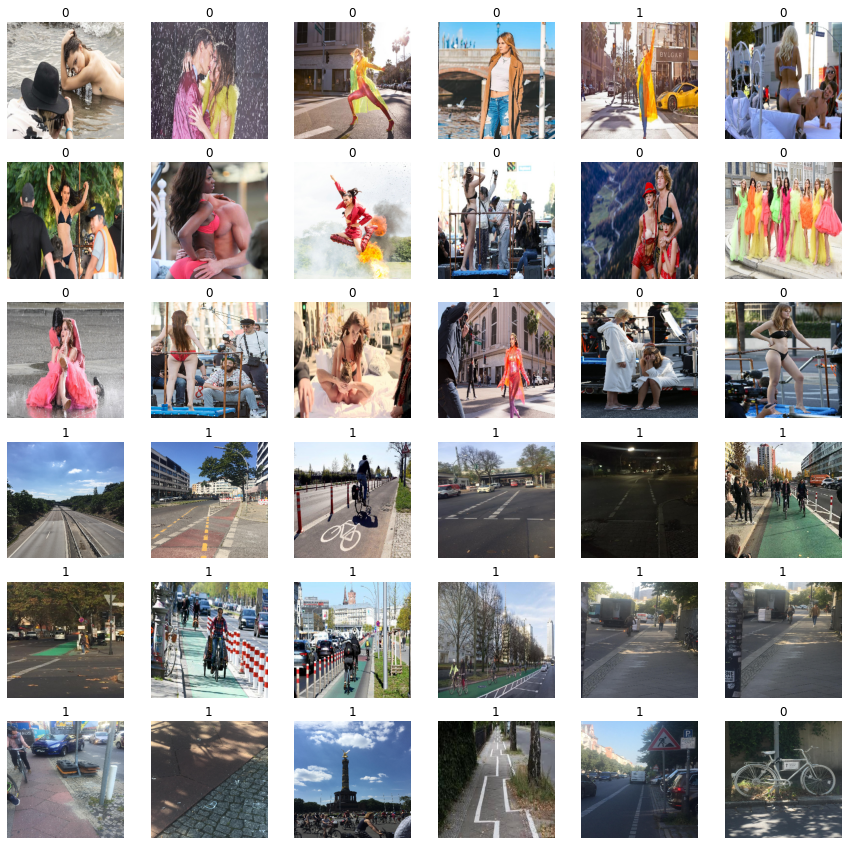

In [30]:
plt.figure(figsize=(15,15))
for n in range(36):
    ax = plt.subplot(6,6,n+1)
    plt.title(y_pred[n])
    plt.imshow(X_test[n])
    plt.axis('off')